# Time Series Wave Height and Wave Period

Wave energy is highly correlated with wave height and with wave period as seen in EDA, with linear regression. Since Wave Energy would not be an available feature directly from live buoy data, it was decided to try to forecast wave height and wave period seperately. This may be more useful in live forecasting and Wave Energy can be derived or estimated from wave height and wave period. 

## Data 
The daily imputed data will be used, containing all features expect for stn_id and Q_Flag.
<details>
  <summary>Data Dictionary</summary>
  
| Field       | Description                                             |
|-------------|---------------------------------------------------------|
| Index       | Date time excluding minutes (used to join df_buoy and df_hind) |
| STN_ID      | Buoy station ID                                         |
| Datetime_x  | Datetime from df_buoy                                  |
| DEPTH       | Depth in meters                                        |
| VWH         | Characteristic significant wave height (reported by the buoy) (m) |
| VCMX        | Maximum zero crossing wave height (reported by the buoy) (m) |
| VTP         | Wave spectrum peak period (reported by the buoy) (s)   |
| WDIR        | Direction from which the wind is blowing (° True)      |
| WSPD        | Horizontal wind speed (m/s)                            |
| WSS         | Horizontal scalar wind speed (m/s)                     |
| GSPD        | Gust wind speed (m/s)                                   |
| ATMS        | Atmospheric pressure at sea level (mbar)               |
| DRYT        | Dry bulb temperature (air temperature) (°C)            |
| SSTP        | Sea surface temperature (°C)                           |
| Q_FLAG      | Quality control flag                                   |
| Datetime_y  | Date time in 3-hour intervals from df_hind             |
| WD          | Wind Direction (deg from which wind is blowing (° True)) |
| WS          | Wind Speed (m/s)                                       |
| ETOT        | Total Variance of Total Spectrum (m^2)                |
| TP          | Peak Spectral Period of Total Spectrum (sec)           |
| VMD         | Vector Mean Direction of Total Spectrum (deg to which) |
| ETTSea      | Total Variance of Primary Partition (m^2)             |
| TPSea       | Peak Spectral Period of Primary Partition (sec)        |
| VMDSea      | Vector Mean Direction of Primary Partition (deg to which) |
| ETTSw       | Total Variance of Secondary Partition (m^2)           |
| TPSw        | Peak Spectral Period of Secondary Partition (sec)      |
| VMDSw       | Vector Mean Direction of Secondary Partition (deg to which) |
| MO1         | First Spectral Moment of Total Spectrum (m^2/s)       |
| MO2         | Second Spectral Moment of Total Spectrum (m^2/s^2)    |
| HS          | Significant Wave Height (m)                            |
| DMDIR       | Dominant Direction (deg to which)                       |
| ANGSPR      | Angular Spreading Function                             |
| INLINE      | In-Line Variance Ratio                                 |

<details>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import month_plot


In [22]:
#import data 
df=pd.read_csv('../Data/df_daily_imputed.csv', index_col=0)

In [23]:
df.head()

,LATITUDE,LONGITUDE,DEPTH,VWH$,VCMX,VTP$,WDIR,WSPD,GSPD,WDIR.1,...,VMDSea,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE
Datetime_buoy,,,,,,,,,,,,,,,,,,,,,
1988-11-22,48.83,126.0,73.0,5.420000,8.400000,11.640000,234.000000,11.800000,15.600000,225.000000,...,32.200000,0.844000,12.229000,63.700000,0.682000,0.564000,3.981000,67.000000,0.807500,0.715300
1988-11-23,48.83,126.0,73.0,6.657391,11.591304,14.960000,265.695652,7.491304,10.630435,256.086957,...,21.869565,0.661391,13.783913,76.808696,1.459913,1.249043,5.604522,52.469565,0.771422,0.673013
1988-11-24,48.83,126.0,73.0,4.434286,7.861905,15.097143,187.095238,6.809524,9.252381,177.619048,...,68.300000,1.774143,14.318143,75.528571,2.440857,1.881714,7.755571,75.142857,0.850457,0.765200
1988-11-25,48.83,126.0,73.0,3.676087,6.047826,13.973913,200.956522,6.026087,8.152174,191.739130,...,44.073913,1.157522,14.076913,88.278261,0.799304,0.618565,4.529000,87.786957,0.859587,0.789322
1988-11-26,48.83,126.0,73.0,3.114091,5.440909,11.930909,236.500000,5.613636,7.395455,227.227273,...,79.350000,0.711591,13.506682,76.372727,0.769818,0.690773,4.112773,89.922727,0.819845,0.757150


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9902 entries, 1988-11-22 to 2016-01-01
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LATITUDE   9902 non-null   float64
 1   LONGITUDE  9902 non-null   float64
 2   DEPTH      9902 non-null   float64
 3   VWH$       9902 non-null   float64
 4   VCMX       9902 non-null   float64
 5   VTP$       9902 non-null   float64
 6   WDIR       9902 non-null   float64
 7   WSPD       9902 non-null   float64
 8   GSPD       9902 non-null   float64
 9   WDIR.1     9902 non-null   float64
 10  WSPD.1     9902 non-null   float64
 11  GSPD.1     9902 non-null   float64
 12  ATMS       9902 non-null   float64
 13  DRYT       9902 non-null   float64
 14  SSTP       9902 non-null   float64
 15  YEAR       9902 non-null   float64
 16  WD         9902 non-null   float64
 17  WS         9902 non-null   float64
 18  ETOT       9902 non-null   float64
 19  TP         9902 non-null   float64
 20

In [25]:
wave_period_data = df[['VTP$']].copy()

In [26]:
wave_height_data =df[['VWH$']].copy()

Text(0.5, 1.0, 'Wave Height(m) over Time')

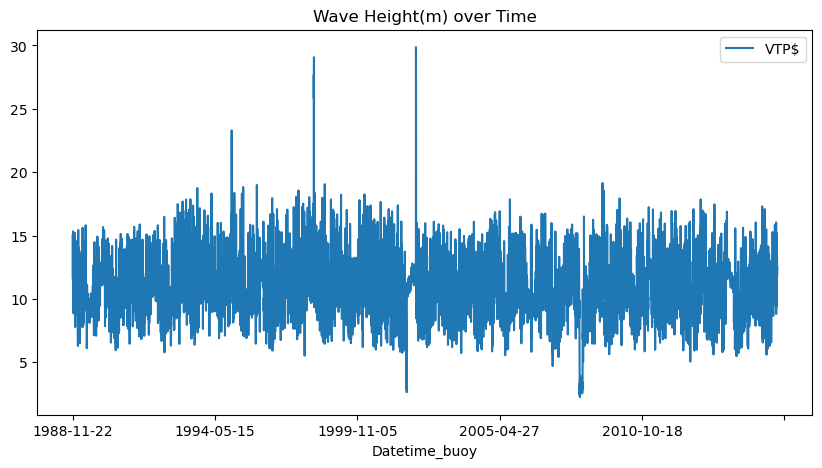

In [27]:

wave_period_data.plot(figsize=(10,5))
plt.title('Wave Height(m) over Time')

<Axes: xlabel='Datetime_buoy'>

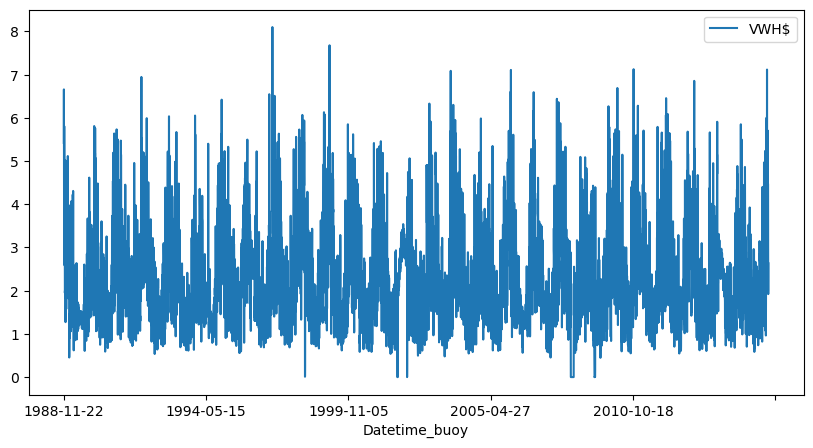

In [28]:
wave_height_data.plot(figsize=(10,5))

## Wave Height Time Series 

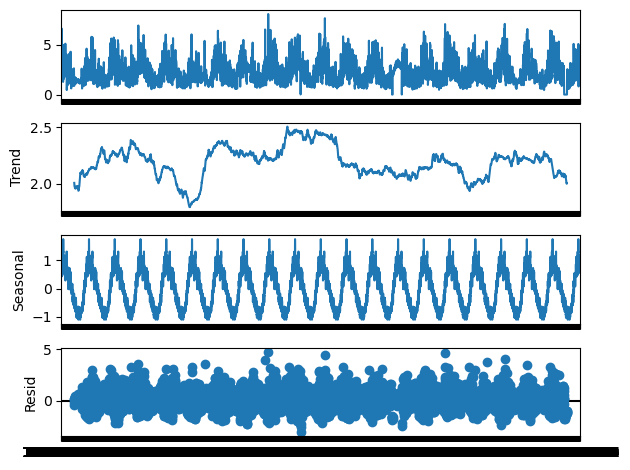

In [9]:
#decompose
result_decomp = seasonal_decompose(wave_height_data, period=365)
result_decomp.plot() #will show entire time range of data set
plt.show()

In [10]:
#AD fuller test for stationarity
result_adf = adfuller(wave_height_data['VWH$'])

test_statistic= result_adf[0]
p_val = result_adf[1]
print(f'Test Statistic: {test_statistic}')
print(f'P-Value: {p_val}')

Test Statistic: -6.841972357732181
P-Value: 1.7817266338021194e-09


Appears that series is stationary according to ADF test. 

Appears that there are stable seasonal patterns that repeat. Use an Additive model. If using auto SARIMA from the pyramid library, this will find the optimal model, so addititive or multiplicative does not need to be specified.

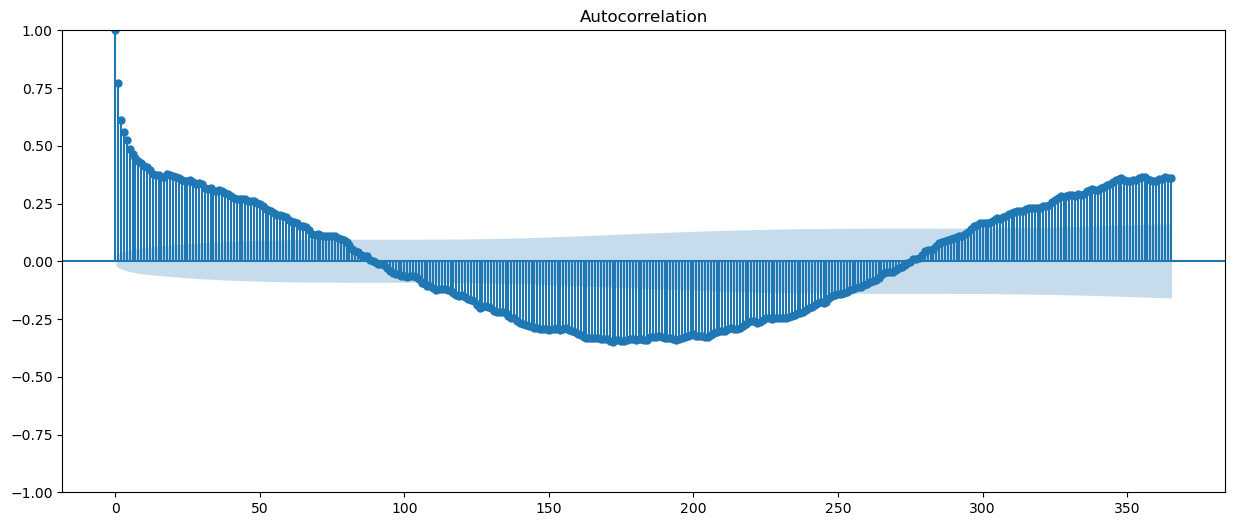

In [11]:
lags= 365
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(wave_height_data,lags=lags,ax=ax)
plt.show()

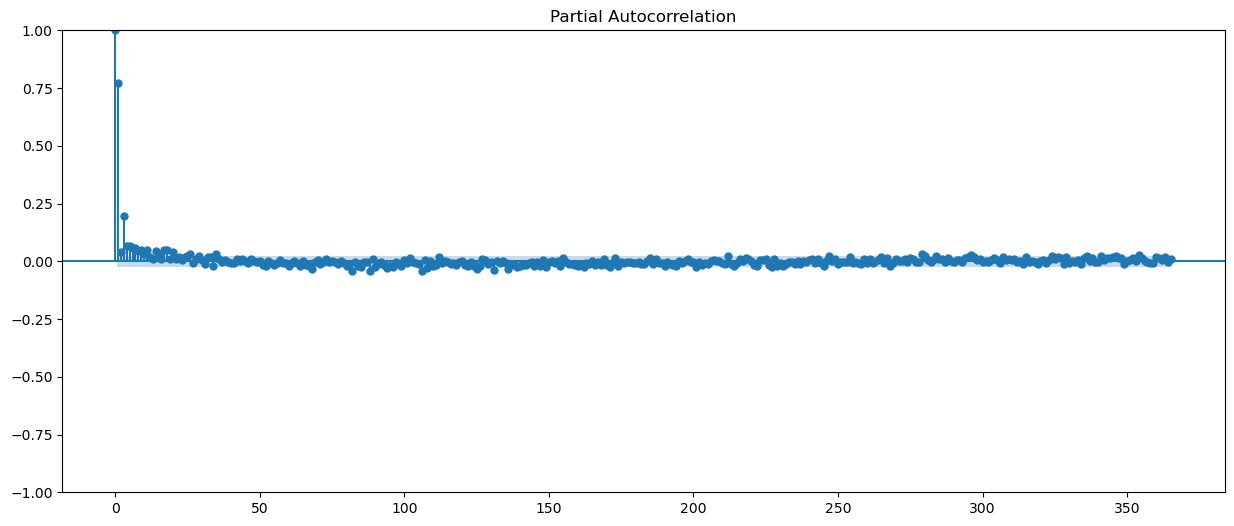

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(wave_height_data,lags=lags,ax=ax)
plt.show()

In [16]:
wave_height_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7345 entries, 1988-11-22 to 2008-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VWH$    7345 non-null   float64
dtypes: float64(1)
memory usage: 114.8+ KB


In [17]:
wave_height_data.index = wave_height_data.index.astype('datetime64[ns]')

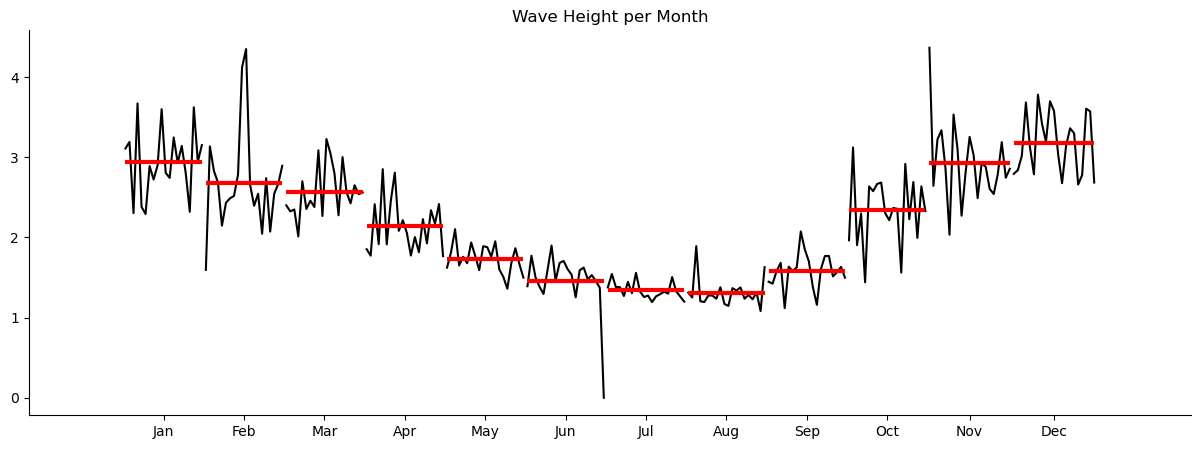

In [20]:
#create month plot of wave height
monthly_wh_data = wave_height_data['VWH$'].resample('M').mean()

plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(monthly_wh_data, ax=plt.gca())

plt.title("Wave Height per Month")
sns.despine()
plt.show()